# Load LPO family

Yuri Shimane

Load LPO family JSON files as pandas dataframe and plot. 
Flip LPO South/North family to generate the North/South family. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from tqdm.notebook import tqdm
import os

%matplotlib inline

In [2]:
import sys
sys.path.append('../')   # path to polaris module

import polaris.SolarSystemConstants as sscs
import polaris.Keplerian as kepl
import polaris.Propagator as prop
import polaris.R3BP as r3bp

In [3]:
param_earth_moon = r3bp.get_cr3bp_param('399','301')   # NAIF ID's '399': Earth, '301': Moon
lp = r3bp.lagrangePoints(param_earth_moon.mu)
param_earth_moon.mu

0.012150584269940354

In [5]:
famdir = '../data/r3bp/EarthMoon/'
os.listdir(famdir)

['.ipynb_checkpoints', 'l2_halo_southern.json']

In [9]:
path = famdir + "l2_halo_southern.json"
famdf = pd.read_json(path, orient="index")
famdf

,System,Family,mu,Period,Jacobi,Stability,state_x,state_y,state_z,state_vx,state_vy,state_vz
0,Earth_Moon,l2_halo_southern,0.012151,3.414576,3.151607,600.775901,1.180784,0,-0.010806,0,-0.156530,0
1,Earth_Moon,l2_halo_southern,0.012151,3.413926,3.151259,597.172483,1.180706,0,-0.014008,0,-0.156985,0
2,Earth_Moon,l2_halo_southern,0.012151,3.413276,3.150912,593.594106,1.180627,0,-0.016602,0,-0.157435,0
3,Earth_Moon,l2_halo_southern,0.012151,3.412626,3.150566,590.040580,1.180548,0,-0.018840,0,-0.157882,0
4,Earth_Moon,l2_halo_southern,0.012151,3.411976,3.150221,586.511718,1.180469,0,-0.020839,0,-0.158325,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2941,Earth_Moon,l2_halo_southern,0.012151,1.502926,3.047122,1.305483,1.021401,0,-0.181665,0,-0.101900,0
2942,Earth_Moon,l2_halo_southern,0.012151,1.502276,3.047172,1.304093,1.021351,0,-0.181631,0,-0.101792,0
2943,Earth_Moon,l2_halo_southern,0.012151,1.501626,3.047222,1.302702,1.021302,0,-0.181596,0,-0.101684,0
2944,Earth_Moon,l2_halo_southern,0.012151,1.500976,3.047271,1.301308,1.021253,0,-0.181562,0,-0.101576,0


In [10]:
proplst = []
for idx in tqdm(range(len(famdf)), desc="Propagating: "):
    state0 = np.array([famdf.iloc[idx,:]["state_x"], famdf.iloc[idx,:]["state_y"], famdf.iloc[idx,:]["state_z"],
                       famdf.iloc[idx,:]["state_vx"], famdf.iloc[idx,:]["state_vy"], famdf.iloc[idx,:]["state_vz"] ])
    proplst.append( prop.propagate_cr3bp(param_earth_moon.mu, state0, famdf.iloc[idx,:]["Period"]) )

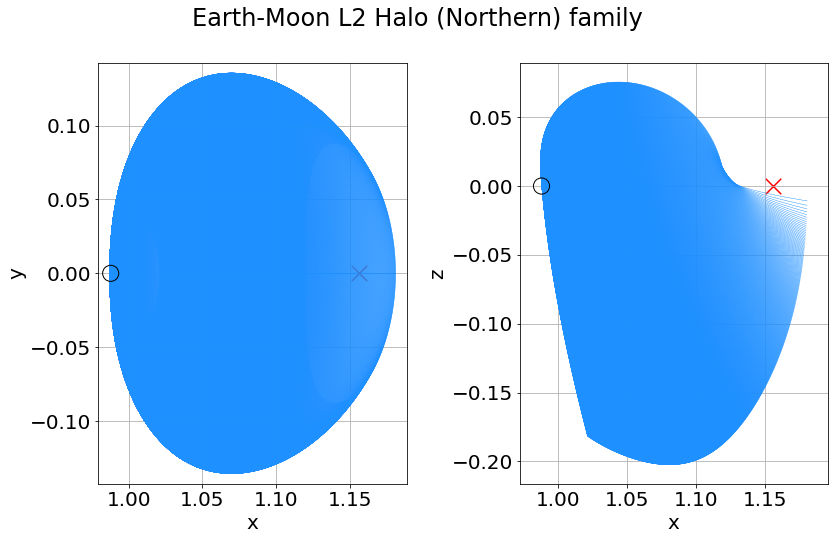

In [11]:
# plot resulting family
plt.rcParams["font.size"] = 20
fig, axs = plt.subplots(1, 2, figsize=(12,8))

for propout in tqdm(proplst):
    axs[0].plot(propout["xs"], propout["ys"], linewidth=0.4, c='dodgerblue', alpha=0.55)
    axs[1].plot(propout["xs"], propout["zs"], linewidth=0.4, c='dodgerblue', alpha=0.55)
    
for idx in range(2):
    axs[idx].grid(True)
    axs[idx].axis("equal")
    axs[idx].scatter(1-param_earth_moon.mu, 0., marker='o', facecolor="none", edgecolor='k', zorder=3, s=260, label='Moon')
    axs[idx].scatter(lp.l2[0], lp.l2[1], marker='x', c='r', s=240)

axs[0].set(xlabel="x", ylabel="y")
axs[1].set(xlabel="x", ylabel="z")

plt.suptitle('Earth-Moon L2 Halo (Northern) family')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

### Flipping to generate Northern family

In [13]:
# initialize pandas dataframe
df_keys = ["System", "Family", "mu", "Period", "Jacobi", "Stability", 
           "state_x", "state_y", "state_z", "state_vx", "state_vy", "state_vz",]
famdf_flip = pd.DataFrame( columns=df_keys )
solcount = 0
for idx in tqdm(range(len(famdf)), desc="Propagating: "):
    # store solution into dataframe
    snew = pd.Series(["Earth_Moon",
                      "l2_halo_northern",
                      param_earth_moon.mu,
                      famdf.iloc[idx,:]["Period"],
                      famdf.iloc[idx,:]["Jacobi"],
                      famdf.iloc[idx,:]["Stability"], 
                      famdf.iloc[idx,:]["state_x"], famdf.iloc[idx,:]["state_y"], -famdf.iloc[idx,:]["state_z"],
                      famdf.iloc[idx,:]["state_vx"], famdf.iloc[idx,:]["state_vy"], -famdf.iloc[idx,:]["state_vz"] ], 
                      index=df_keys, name=int(solcount))
    # append to dataframe
    famdf_flip = pd.DataFrame.append(famdf_flip, snew)
    solcount += 1

In [14]:
proplst_flip = []
for idx in tqdm(range(len(famdf_flip)), desc="Propagating: "):
    state0 = np.array([famdf_flip.iloc[idx,:]["state_x"], famdf_flip.iloc[idx,:]["state_y"], famdf_flip.iloc[idx,:]["state_z"],
                       famdf_flip.iloc[idx,:]["state_vx"], famdf_flip.iloc[idx,:]["state_vy"], famdf_flip.iloc[idx,:]["state_vz"] ])
    proplst_flip.append( prop.propagate_cr3bp(param_earth_moon.mu, state0, famdf_flip.iloc[idx,:]["Period"]) )

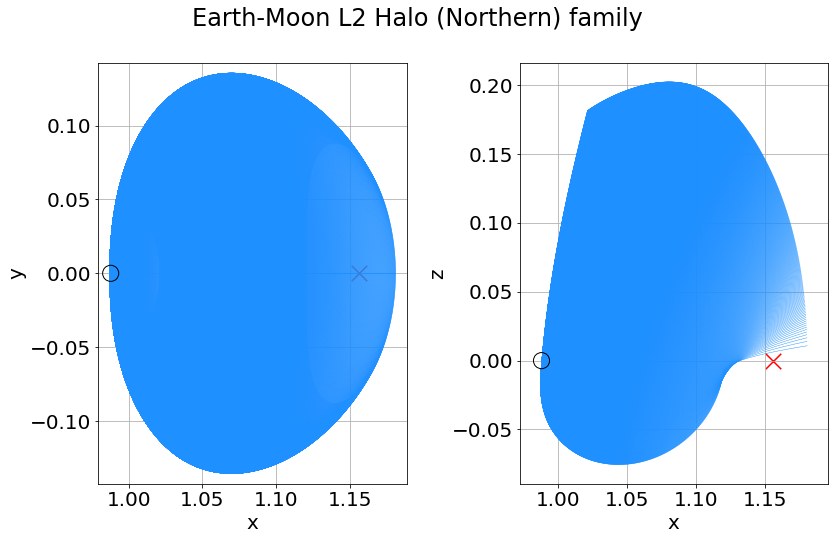

In [15]:
# plot resulting family
plt.rcParams["font.size"] = 20
fig, axs = plt.subplots(1, 2, figsize=(12,8))

for propout in tqdm(proplst_flip):
    axs[0].plot(propout["xs"], propout["ys"], linewidth=0.4, c='dodgerblue', alpha=0.55)
    axs[1].plot(propout["xs"], propout["zs"], linewidth=0.4, c='dodgerblue', alpha=0.55)
    
for idx in range(2):
    axs[idx].grid(True)
    axs[idx].axis("equal")
    axs[idx].scatter(1-param_earth_moon.mu, 0., marker='o', facecolor="none", edgecolor='k', zorder=3, s=260, label='Moon')
    axs[idx].scatter(lp.l2[0], lp.l2[1], marker='x', c='r', s=240)

axs[0].set(xlabel="x", ylabel="y")
axs[1].set(xlabel="x", ylabel="z")

plt.suptitle('Earth-Moon L2 Halo (Northern) family')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

In [16]:
raise SystemExit("Stop before stopping!")

SystemExit: Stop before stopping!

C:\Users\yurio\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [17]:
# save output
flename = "l2_halo_northern_test.json"
pathjson = '../data/r3bp/EarthMoon/' + flename
famdf.to_json(pathjson, orient='index', indent=4, double_precision=15)

print(f'Done! Saved at {pathjson}')

Done! Saved at ../data/r3bp/EarthMoon/l2_halo_northern_test.json
